In [1]:
# Data management
import pandas as pd

# Math and Stat modules
import numpy as np

# Data preprocessing and trasformation (ETL)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

#Imputer
from sklearn.impute import SimpleImputer

#Supervised Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, RepeatedKFold, ShuffleSplit, StratifiedShuffleSplit, learning_curve, validation_curve, cross_validate
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, accuracy_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

#Artificial Neural Network
from tensorflow import keras
from scikeras.wrappers import KerasClassifier, KerasRegressor
from keras import backend as K

# Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

# Presentazione problema

Partendo dai dati dei clienti di una compagnia cercare di ottimizzare i risultati di una campagna di marketing cercando di predirre chi risponderà positivamente a un'offerta così da massimizzare il profitto della campagna di marketing.

Dataset: [https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign](https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign)

In [2]:
pd.set_option("max_colwidth", 200)
pd.read_csv("data/columnsInfo.csv", sep=";")

,Column's name,Description
0,ID,Customer's id
1,Year_Birth,Customer's year of birth
2,Education,Customer’s level of education
3,Marital_Status,Customer’s marital status
4,Income,Customer’s yearly household income
5,Kidhome,Number of small children in customer’s household
6,Teenhome,Number of teenagers in customer’s household
7,Dt_Customer,Date of customer’s enrolment with the company
8,Recency,Number of days since the last purchase
9,MntWines,Amount spent on wine products in the last 2 years


# ETL Processing

In [3]:
dataset = pd.read_csv("data/marketing_campaign.csv", sep=";")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
dataset.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


In [5]:
dataset.drop(columns=['ID', 'Z_CostContact', 'Z_Revenue'], inplace=True)

Prendo le Label

In [6]:
dataset_label = dataset['Response']
dataset.drop(columns=['Response'], inplace=True)

Guardo come sono distribuiti i dati per preprocessarli

array([[<AxesSubplot:title={'center':'Year_Birth'}>,
        <AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Kidhome'}>,
        <AxesSubplot:title={'center':'Teenhome'}>,
        <AxesSubplot:title={'center':'Recency'}>],
       [<AxesSubplot:title={'center':'MntWines'}>,
        <AxesSubplot:title={'center':'MntFruits'}>,
        <AxesSubplot:title={'center':'MntMeatProducts'}>,
        <AxesSubplot:title={'center':'MntFishProducts'}>,
        <AxesSubplot:title={'center':'MntSweetProducts'}>],
       [<AxesSubplot:title={'center':'MntGoldProds'}>,
        <AxesSubplot:title={'center':'NumDealsPurchases'}>,
        <AxesSubplot:title={'center':'NumWebPurchases'}>,
        <AxesSubplot:title={'center':'NumCatalogPurchases'}>,
        <AxesSubplot:title={'center':'NumStorePurchases'}>],
       [<AxesSubplot:title={'center':'NumWebVisitsMonth'}>,
        <AxesSubplot:title={'center':'AcceptedCmp3'}>,
        <AxesSubplot:title={'center':'AcceptedCmp4'}>,
 

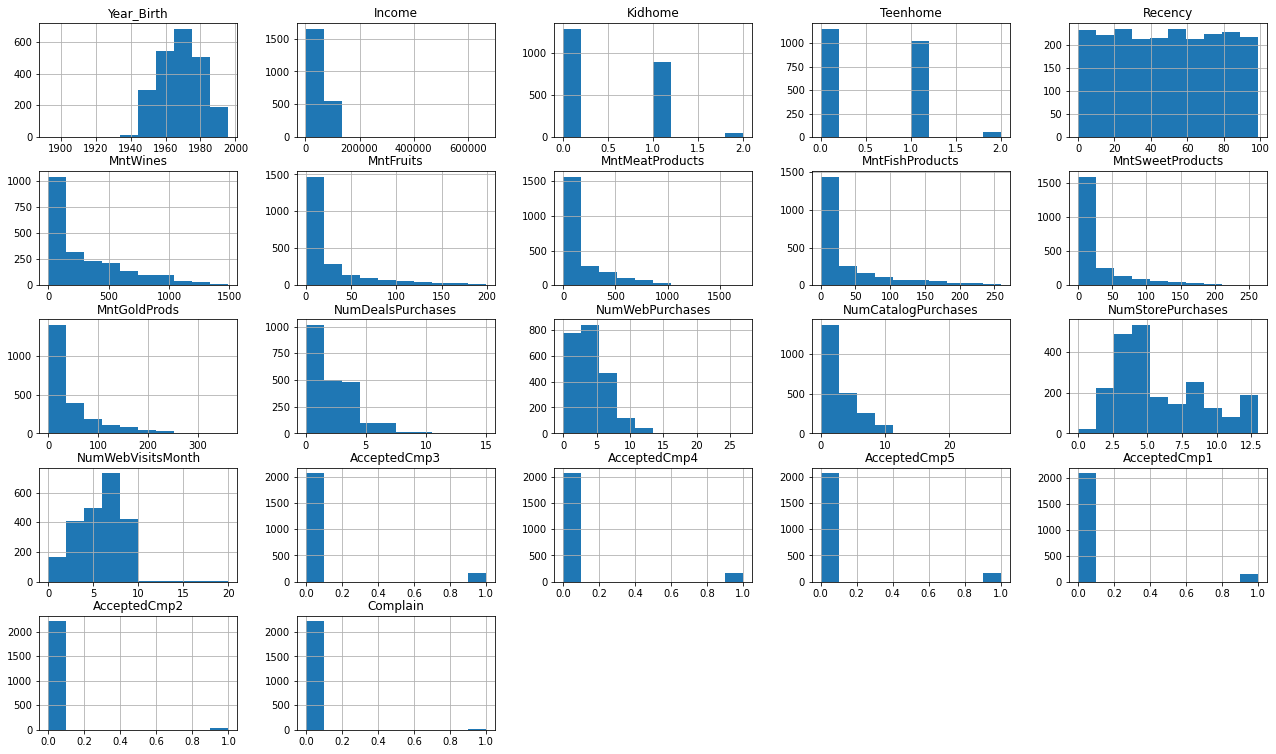

In [7]:
dataset.hist(figsize=(22,13))

In [8]:
class DateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, startDate = pd.to_datetime("2015-01-01")):
        self.startDate = startDate
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_new = pd.to_datetime(X.iloc[:,0])
        X_new = pd.DataFrame((self.startDate - X_new).transform(lambda days: days.total_seconds()/(60*60*24*30)))
        return X_new

In [9]:
income_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

date_pipeline = Pipeline([
    ('transformer', DateTransformer()),
    ('scaler', StandardScaler())
])

normal_features = ['Year_Birth', 'NumWebVisitsMonth', 'NumWebPurchases', 'NumCatalogPurchases', 'NumDealsPurchases', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

In [10]:
data_preprocessing = ColumnTransformer([
    ('normal', MinMaxScaler(), normal_features),
    ('cat', OneHotEncoder(), ['Education', 'Marital_Status']),
    ('income', income_pipeline, ['Income']),
    ('dateSubscription', date_pipeline, ["Dt_Customer"]),
    ('sparse', MaxAbsScaler(), ['Recency', 'NumStorePurchases'])
],
    remainder = 'passthrough'
)

feature_matrix = data_preprocessing.fit_transform(dataset)

# Algoritmi/modelli da utilizzare

Si utilizzeranno i seguenti modelli di ML:
- Perceptron
- Logistic Regression 
- Support Vector Machine
- Decision Tree
- Bagging con Decision Tree
- Ada Boost con Decision Tree
- Gradient Boosting
- Random Forest
- Neural Network
- Voting Classifier con tutti i classificatori precedenti

In [11]:
final_scores = [] #Name, predictions, train_size, train_scores, test_scores
voting_estimators = []

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [12]:
def drawAccuracy(train_size, train_scores, test_scores):
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    fig=plt.figure(figsize=(12,7))
    ax = fig.add_subplot()

    ax.plot(train_size, train_mean,
             color='blue', marker='+',
             markersize=5, label='Training accuracy')

    ax.fill_between(train_size,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    ax.plot(train_size, test_mean,
             color='green', linestyle='--',
             marker='d', markersize=5,
             label='Validation accuracy')

    ax.fill_between(train_size,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    ax.grid()
    ax.set_xlabel('Dimensione del training set')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_ylim([0.6, 1.03])

## Perceptron

In [13]:
estimator = Perceptron(n_jobs=-1)

param_grid = {'alpha': [0.00001, 0.0001, 0.001], "penalty": ['l2','l1','elasticnet', None]}
grid_search = GridSearchCV(estimator=estimator, param_grid = param_grid, cv = cv, scoring = 'f1', n_jobs = -1)
grid_search.fit(X=feature_matrix, y=dataset_label)
estimator = grid_search.best_estimator_

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)
print(grid_search.best_params_)

{'alpha': 0.0001, 'penalty': 'l2'}


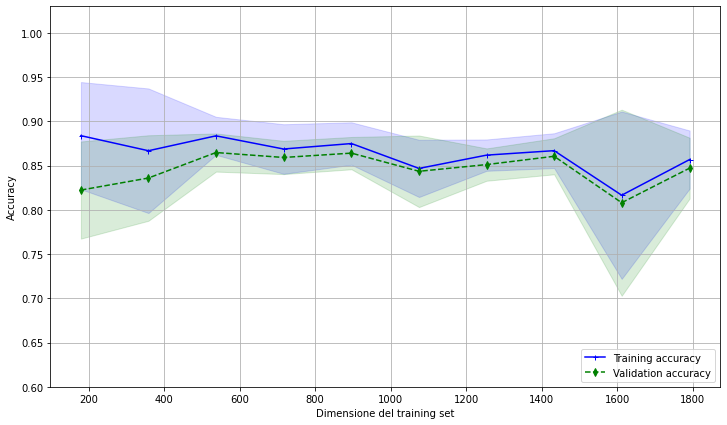

In [14]:
drawAccuracy(train_size, train_scores, test_scores)

In [15]:
voting_estimators.append(("Perceptron", estimator))
final_scores.append(("Perceptron", scores, train_size, train_scores, test_scores))

## Logistic Regression

In [16]:
estimator = LogisticRegression(max_iter=1000, n_jobs = -1)

param_grid = {"C": [0.01, 0.1, 1, 2, 3], "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring= 'f1', n_jobs = -1)
grid_search.fit(X=feature_matrix, y=dataset_label)
estimator = grid_search.best_estimator_

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)
print(grid_search.best_params_)

{'C': 1, 'solver': 'sag'}


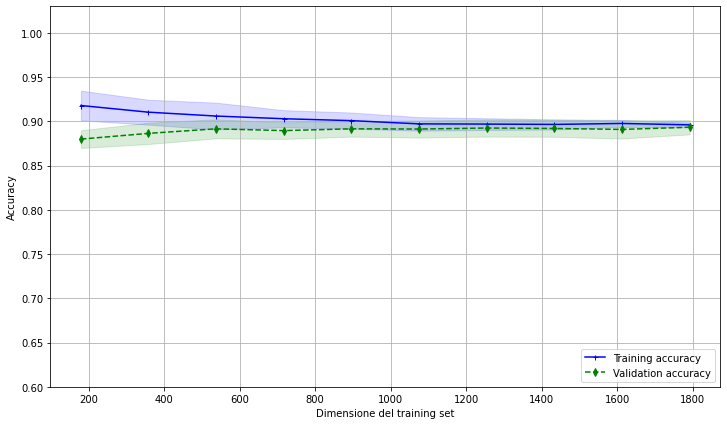

In [17]:
drawAccuracy(train_size, train_scores, test_scores)

In [18]:
voting_estimators.append(("Logistic Regression", estimator))
final_scores.append(("Logistic Regression", scores, train_size, train_scores, test_scores))

## SVC

In [19]:
gamma1, gamma2 = 0.1, 2
C1, C2 = 0.01, 5
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

train_sizes, train_means, test_means, test_stds, train_stds, SVC_predictions = [],[],[],[],[],[]
for gamma, C in hyperparams:
    svc_cls = SVC(kernel="rbf", gamma = gamma, C = C)
    train_size, train_scores, test_scores = learning_curve(svc_cls, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv=cv, n_jobs=-1)
    train_means.append(np.mean(train_scores, axis=1))
    train_stds.append(np.std(train_scores, axis=1))
    test_means.append(np.mean(test_scores, axis=1))
    test_stds.append(np.std(test_scores, axis=1))
    train_sizes.append(train_size)

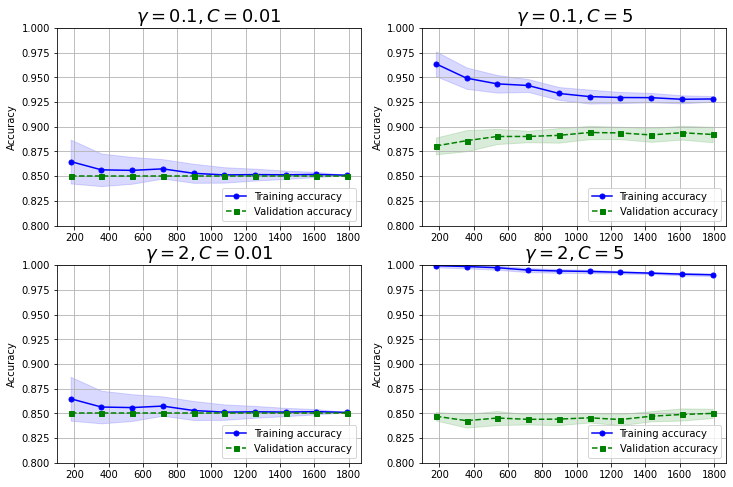

In [20]:
fig= plt.figure(figsize=(12, 8))
for i in range(4):
    ax = fig.add_subplot(221+i)
    ax.plot(train_sizes[i], train_means[i],
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes[i],
                 train_means[i] + train_stds[i],
                 train_means[i] - train_stds[i],
                 alpha=0.15, color='blue')
    ax.plot(train_sizes[i], test_means[i],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_sizes[i],
                 test_means[i] + test_stds[i],
                 test_means[i] - test_stds[i],
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.8,1))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(r"$\gamma={}, C={}$".format(*hyperparams[i]), fontsize=18)

In [ ]:
estimator = SVC()

param_grid = [
    {'kernel': ['rbf'], 'gamma': [0.01, 0.1, 1, 2, 3], 'C': [0.01, 0.1, 1, 2, 3]},
    {'kernel': ['poly'], 'degree': [1, 2, 3, 4, 5], 'coef0': [1, 10, 50, 100]}
]
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring= 'f1', n_jobs = -1)
grid_search.fit(X=feature_matrix, y=dataset_label)
estimator = grid_search.best_estimator_

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)
print(grid_search.best_params_)

In [ ]:
drawAccuracy(train_size, train_scores, test_scores)

In [23]:
voting_estimators.append(("SVC", estimator))
final_scores.append(("SVC", scores, train_size, train_scores, test_scores))

## Decision Tree

In [24]:
min_leaf = [20, 30, 40, 50, 100]

train_sizes, train_means, test_means, test_stds, train_stds = [],[],[],[],[]
for mlf in min_leaf:
    dt_clf = DecisionTreeClassifier(min_samples_leaf=mlf, random_state=42, max_depth=15)
    train_size, train_scores, test_scores = learning_curve(dt_clf, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv=cv, n_jobs=-1)
    train_means.append(np.mean(train_scores, axis=1))
    train_stds.append(np.std(train_scores, axis=1))
    test_means.append(np.mean(test_scores, axis=1))
    test_stds.append(np.std(test_scores, axis=1))
    train_sizes.append(train_size)

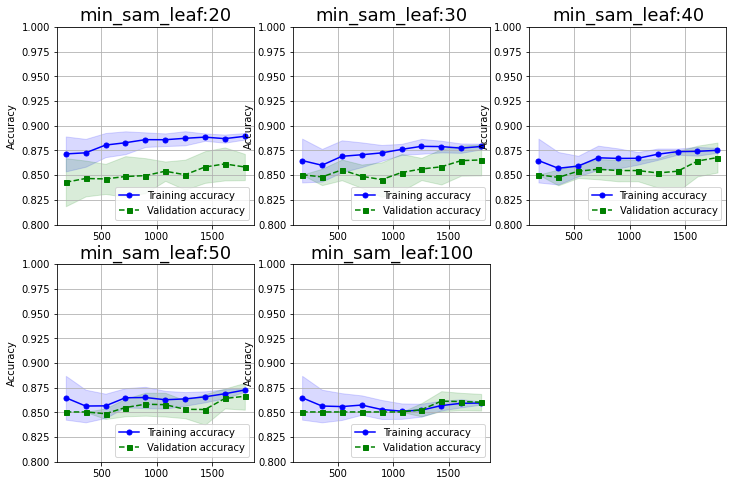

In [25]:
fig= plt.figure(figsize=(12, 8))
for i in range(5):
    ax = fig.add_subplot(231+i)
    ax.plot(train_sizes[i], train_means[i],
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_sizes[i],
                 train_means[i] + train_stds[i],
                 train_means[i] - train_stds[i],
                 alpha=0.15, color='blue')
    ax.plot(train_sizes[i], test_means[i],
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_sizes[i],
                 test_means[i] + test_stds[i],
                 test_means[i] - test_stds[i],
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.8,1))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(r"min_sam_leaf:{}".format(min_leaf[i]), fontsize=18)

In [31]:
estimator = DecisionTreeClassifier(random_state=42)

param_grid = {"splitter": ["best", "random"], "min_samples_leaf": [2, 5, 10, 20], "max_depth": [15, 20, 25]}
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring= 'f1', n_jobs = -1)
grid_search.fit(X=feature_matrix, y=dataset_label)
estimator = grid_search.best_estimator_
best_tree_cls = estimator

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)
print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 10, 'splitter': 'random'}


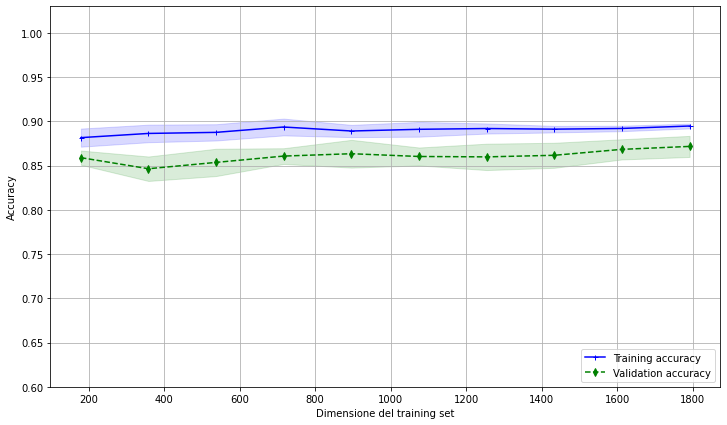

In [32]:
drawAccuracy(train_size, train_scores, test_scores)

In [33]:
voting_estimators.append(("Decision Tree", estimator))
final_scores.append(("Decision Tree", scores, train_size, train_scores, test_scores))

## Bagging

In [ ]:
estimator = BaggingClassifier(best_tree_cls, n_estimators=250, n_jobs=-1)

param_grid = {"max_samples": [250, 500, 1000], "bootstrap": [True, False]}
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring= 'f1', n_jobs = -1)
grid_search.fit(X=feature_matrix, y=dataset_label)
estimator = grid_search.best_estimator_

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)
print(grid_search.best_params_)

{'bootstrap': False, 'max_samples': 1000}


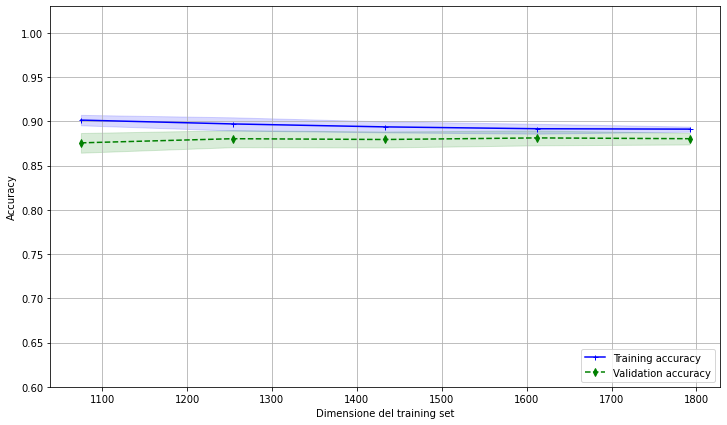

In [ ]:
drawAccuracy(train_size, train_scores, test_scores)

In [36]:
voting_estimators.append(("Bagging", estimator))
final_scores.append(("Bagging", scores, train_size, train_scores, test_scores))

## Ada Boost

In [45]:
estimator = AdaBoostClassifier(best_tree_cls, n_estimators=250, random_state=42)

param_grid = {"algorithm": ['SAMME', 'SAMME.R'], "learning_rate": [0.1, 1, 2, 10]}
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring= 'f1', n_jobs = -1)
grid_search.fit(X=feature_matrix, y=dataset_label)
estimator = grid_search.best_estimator_

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)
print(grid_search.best_params_)

{'algorithm': 'SAMME', 'learning_rate': 1}


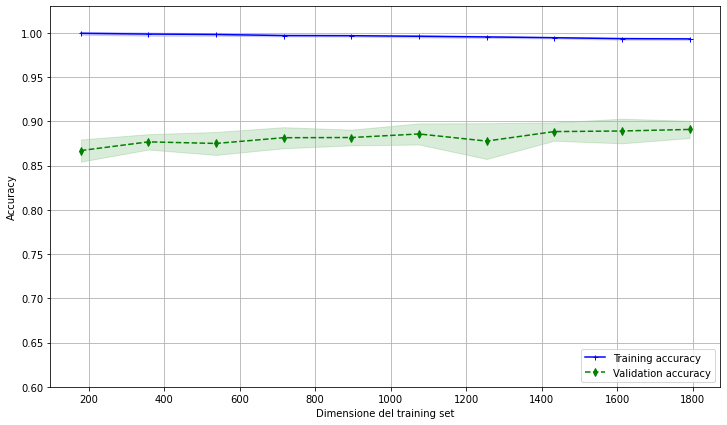

In [46]:
drawAccuracy(train_size, train_scores, test_scores)

In [34]:
voting_estimators.append(("Ada Boost", estimator))
final_scores.append(("Ada Boost", scores, train_size, train_scores, test_scores))

## Gradient Boosting

In [53]:
estimator = GradientBoostingClassifier(n_estimators=250)

param_grid = {"min_samples_leaf": [1, 5, 10], "max_features": [5, 10, 20], "max_leaf_nodes": [2, 3, 4]}
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring= 'f1', n_jobs = -1)
grid_search.fit(X=feature_matrix, y=dataset_label)
estimator = grid_search.best_estimator_

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)
print(grid_search.best_params_)

{'max_features': 10, 'max_leaf_nodes': 3, 'min_samples_leaf': 5}


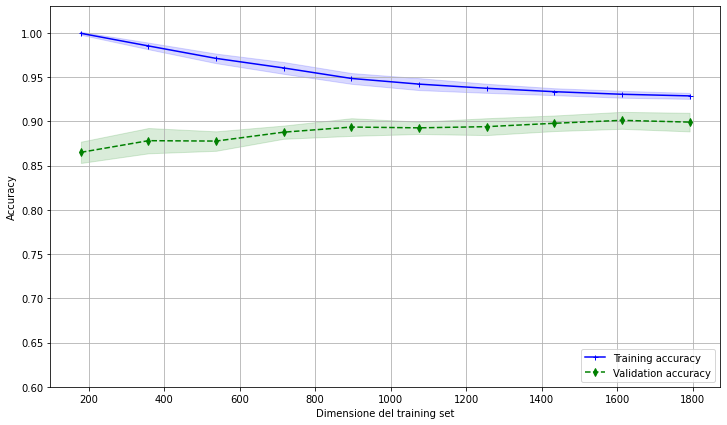

In [54]:
drawAccuracy(train_size, train_scores, test_scores)

In [37]:
voting_estimators.append(("Gradient Boosting", estimator))
final_scores.append(("Gradient Boosting", scores, train_size, train_scores, test_scores))

## Random Forest

In [55]:
estimator = RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=42)

param_grid = {"min_samples_leaf": [1, 2, 5, 10], "max_features": [5, 10, 20], "max_leaf_nodes": [2, 3, 4]}
grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, scoring= 'f1', n_jobs = -1)
grid_search.fit(X=feature_matrix, y=dataset_label)
estimator = grid_search.best_estimator_

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)
train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)
print(grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
drawAccuracy(train_size, train_scores, test_scores)

In [40]:
voting_estimators.append(("Random Forest", estimator))
final_scores.append(("Random Forest", scores, train_size, train_scores, test_scores))

## Neural Network

In [44]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [45]:
scores = {"test_accuracy":[],"test_precision":[],"test_recall":[],"test_f1":[],"test_loss":[]}
for train_index, test_index in cv.split(feature_matrix, dataset_label):
    X_train = feature_matrix[train_index]
    X_test = feature_matrix[test_index]
    y_train = dataset_label[train_index]
    y_test = dataset_label[test_index]
    
    model = None
    model = keras.models.Sequential([
        keras.layers.Input(shape=feature_matrix.shape[1:]),
        keras.layers.Dense(36),
        keras.layers.Dense(10),
        keras.layers.Dense(1)
    ])
    model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=['acc', precision, recall, f1])
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=300, callbacks=[early_stopping_cb], validation_data=(X_test, y_test), verbose=0)
    loss_score, accuracy_score, precision_score, recall_score, f1_score = model.evaluate(X_test, y_test, verbose=0)

    scores["test_accuracy"].append(accuracy_score)
    scores["test_precision"].append(precision_score)
    scores["test_recall"].append(recall_score)
    scores["test_f1"].append(f1_score)
    scores["test_loss"].append(loss_score)

In [46]:
scores = {k: np.array(v) for k, v in scores.items()}
final_scores.append(("Neural Network", scores, None, None, None))

## Voting Classifier

In [47]:
estimator = VotingClassifier(estimators=voting_estimators, voting='hard')

scores = cross_validate(estimator, X=feature_matrix, y=dataset_label, cv = cv, scoring = scoring, n_jobs=-1)

train_size, train_scores, test_scores = learning_curve(estimator, X=feature_matrix, y=dataset_label, train_sizes=np.linspace(0.1,1.0,10), cv = cv, n_jobs = -1)

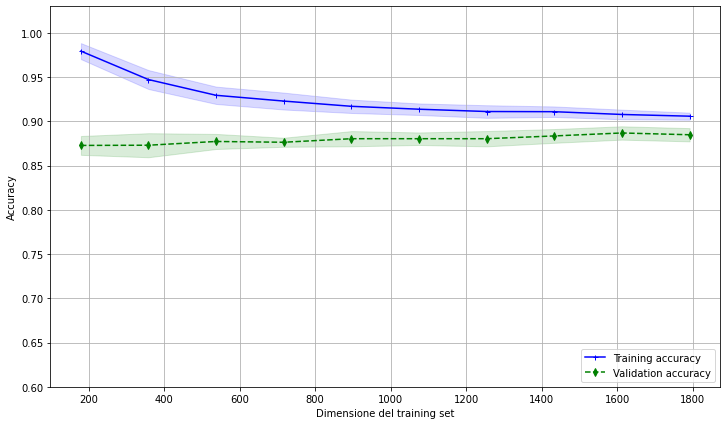

In [48]:
drawAccuracy(train_size, train_scores, test_scores)

In [49]:
final_scores.append(("Voting Classifier", scores, train_size, train_scores, test_scores))

# Cross-validation

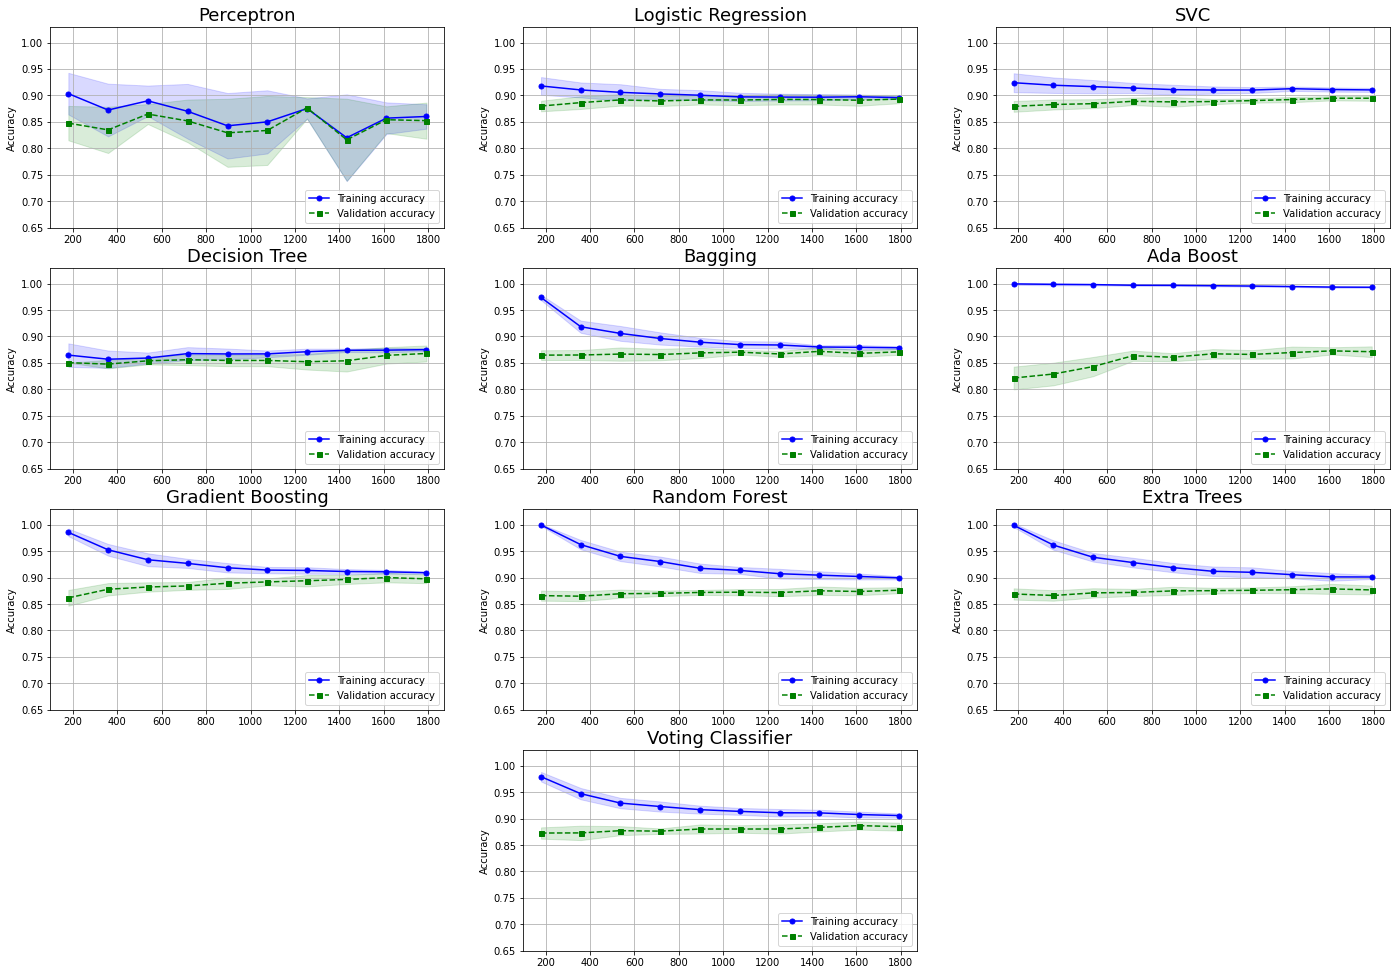

In [91]:
fig= plt.figure(figsize=(24, 17))
for i, (name, _, train_size, train_scores, test_scores) in enumerate(final_scores):
    if name == "Neural Network":
        continue
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    ax = fig.add_subplot(4,3,1+i)
    ax.plot(train_size, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')
    ax.fill_between(train_size,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')
    ax.plot(train_size, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')
    ax.fill_between(train_size,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
    ax.grid()
    ax.set_ylim((0.65,1.03))
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    ax.set_title(name, fontsize=18)

In [51]:
columns = [colName.title() for colName in scoring]+["Loss"]
final_table = pd.DataFrame(columns=columns)
for (name, score, train_size, train_scores, test_scores) in final_scores:
    data = []
    for metric in scoring:
        data.append(score['test_'+metric].mean())
    data.append(score['test_loss'].mean()) if name=="Neural Network" else data.append(None)
    final_table = pd.concat([final_table, pd.DataFrame([data], columns=columns, index=[name])])

In [52]:
dfstyle = [dict(selector="th", props=[('font-size', '20pt')]),dict(selector="td", props=[('font-size', '20pt')])]
final_table.style.set_table_styles(dfstyle).background_gradient(axis=0, cmap=sns.light_palette("green", as_cmap=True))

,Accuracy,Precision,Recall,F1,Loss
Perceptron,0.852232,0.569825,0.483582,0.480814,nan
Logistic Regression,0.893080,0.729693,0.452239,0.557983,nan
SVC,0.894643,0.829621,0.374627,0.514659,nan
Decision Tree,0.867857,0.649627,0.274627,0.382606,nan
Bagging,0.869866,0.788489,0.185075,0.297725,nan
Ada Boost,0.867188,0.638117,0.256716,0.365377,nan
Gradient Boosting,0.897545,0.812826,0.410448,0.544269,nan
Random Forest,0.875223,0.813259,0.216418,0.340350,nan
Extra Trees,0.874777,0.814696,0.211940,0.334280,nan
Neural Network,0.890848,0.702143,0.359943,0.445622,0.085461


<AxesSubplot:>

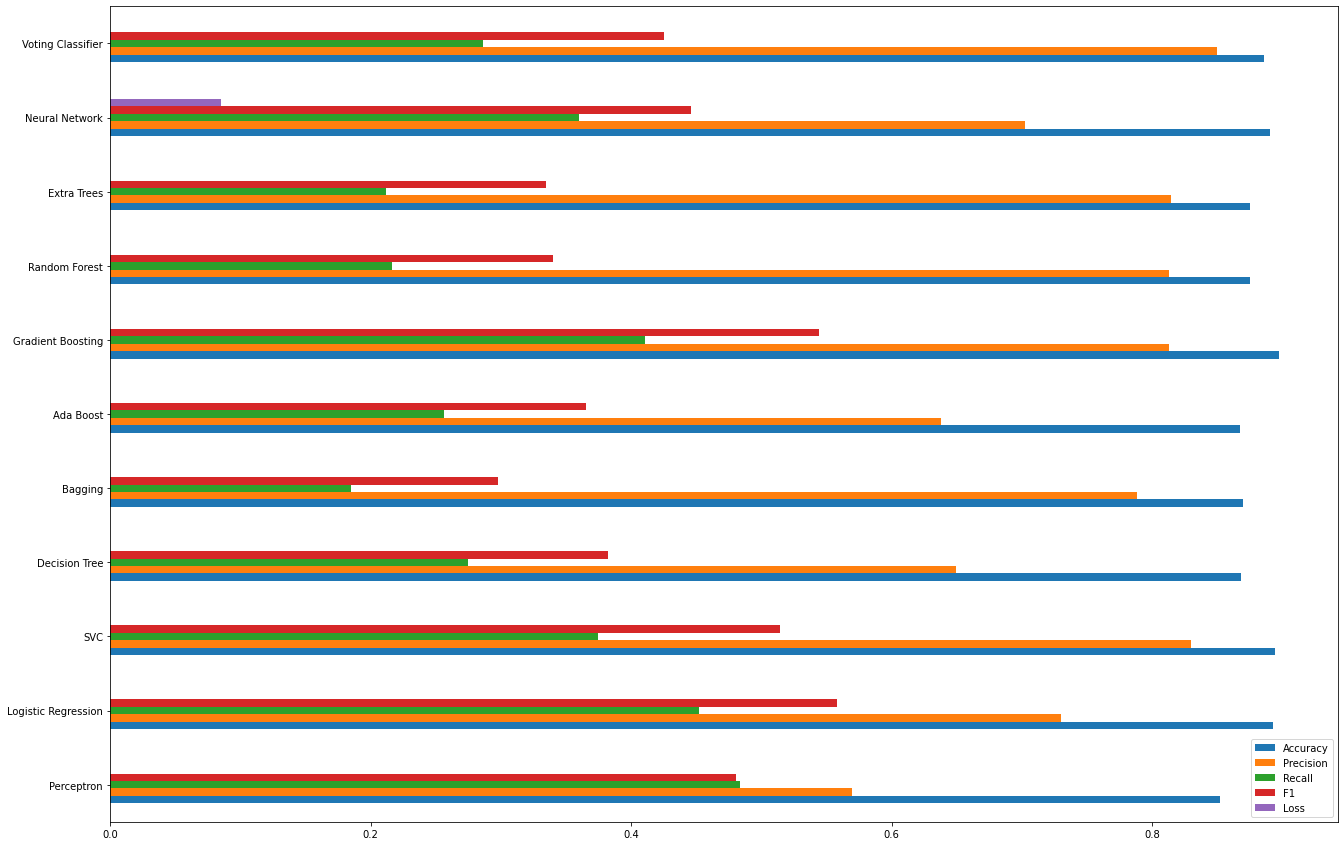

In [73]:
final_table.plot(kind="barh", figsize=(22,15))

In [86]:
def visualize_performance(ax, scores, metric):
    data_score = []
    labels = []
    for (name, score, _, _, _) in scores:
        labels.append(name)
        data_score.append(score['test_'+metric])
    sns.boxplot(ax = ax, data = data_score, whis = [5, 95], palette = "vlag", orient = 'h')
    ax.set(yticklabels=labels)

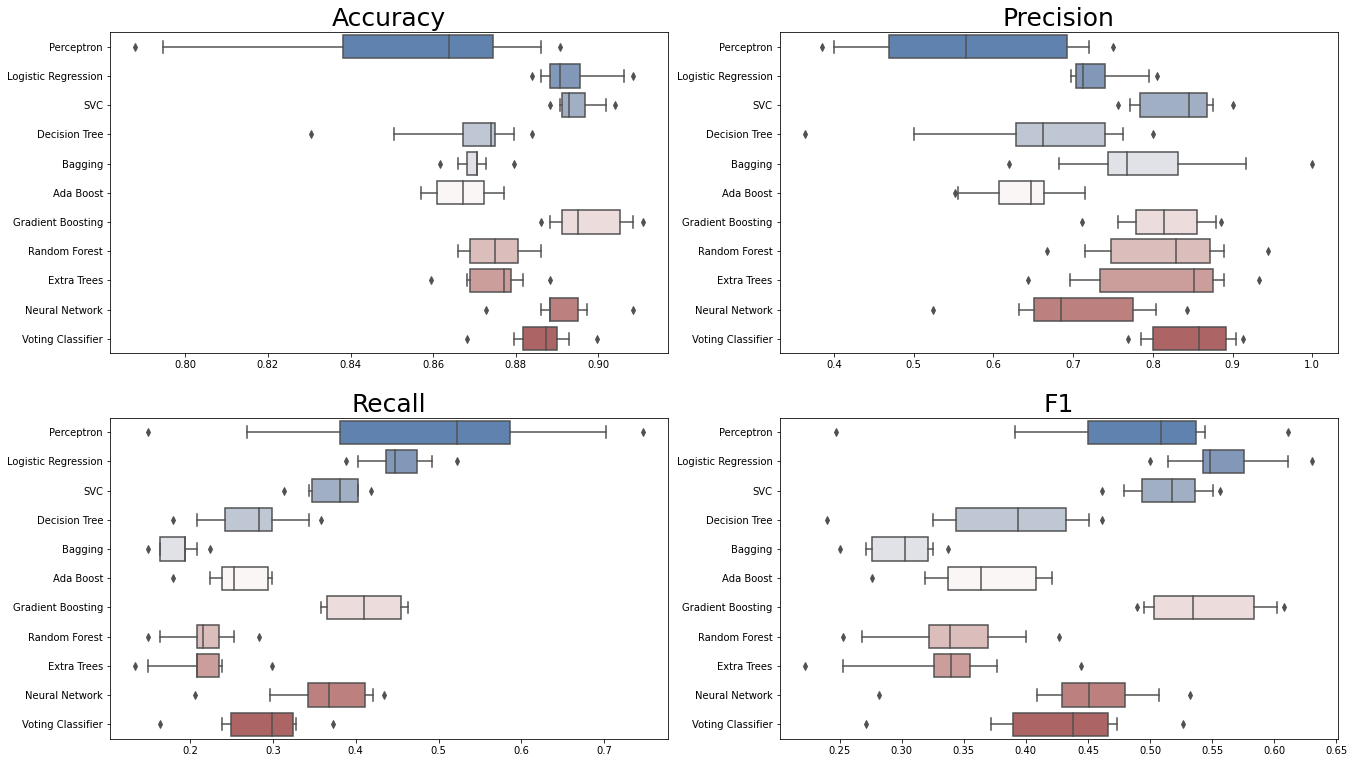

In [87]:
fig= plt.figure(figsize=(22, 13))
for i, metric in enumerate(scoring):
    ax = fig.add_subplot(2,2,1+i)
    visualize_performance(ax, final_scores, metric)
    ax.set_title(metric.title(), fontsize=25)

Text(0.5, 1.0, 'Loss')

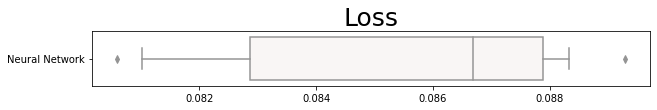

In [88]:
fig= plt.figure(figsize=(10, 1))
ax = fig.add_subplot()
nn_score = [score for score in final_scores if "test_loss" in score[1]]
visualize_performance(ax, nn_score, "loss")
ax.set_title("Loss", fontsize=25)

# Conclusioni

ALTA PRECISION = Alta probabilità di successo ma rischio di non contattare potenziali clienti interessati all'offerta

ALTA RECALL = Probabilità più bassa di successo ma rischio minore di non contattare potenziali clienti interessati all'offerta 

Per il contesto nel quale ci troviamo probabilmente preferiremmo avere una f1 alta ma se dovessimo scegliere una recall alta è preferibile rispetto a una precision alta dato che contattare potenziali clienti interessati all'offerta porterebbe un profitto maggiore al costo di scomodare clienti non interessati e però avere una campagna di marketing più costosa.

Dato che il **Perceptron** è quello con la recall più alta ma ha gli altri valori abbastanza bassi sceglieremo il **Gradient Boosting** dato che è il secondo modello con la recall più alta e tutti gli altri valori alti.